In [1]:
# ! uv pip install gplearn

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_openml

boston = fetch_openml(name="boston", version=1, as_frame=True)

df = boston.frame
df.rename(columns={'MEDV': 'target'}, inplace=True)

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(df.drop('target', axis=1), df['target'])

y_pred = model.predict(df.drop('target', axis=1))

for actual, pred in list(zip(df['target'][:5], y_pred[:5])):
    print(f"Actual target: {actual:.1f}, Predicted MEDV: {pred:.2f}")


Actual target: 24.0, Predicted MEDV: 25.18
Actual target: 21.6, Predicted MEDV: 21.78
Actual target: 34.7, Predicted MEDV: 35.03
Actual target: 33.4, Predicted MEDV: 33.77
Actual target: 36.2, Predicted MEDV: 35.50


In [4]:
import numpy as np

# Compute squared residuals for each instance
residuals = (df['target'] - y_pred) ** 2

# Append residuals as a new column in the DataFrame
df['Residual'] = residuals

# Quick check on residual statistics
print("Residual column added. Summary of residuals:")
print(df['Residual'].describe())


Residual column added. Summary of residuals:
count    506.000000
mean       1.439319
std        4.399521
min        0.000049
25%        0.068780
50%        0.294849
75%        1.009523
max       63.250209
Name: Residual, dtype: float64


In [5]:
# Save the DataFrame with residuals to a CSV file for later use
df.to_csv("boston_housing_with_residuals.csv", index=False)
print("Dataset with residuals saved to 'boston_housing_with_residuals.csv'.")


Dataset with residuals saved to 'boston_housing_with_residuals.csv'.


In [6]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,Residual
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0,1.404225
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6,0.034225
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7,0.110889
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4,0.139129
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2,0.483025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4,0.370881
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6,0.714025
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9,3.171961
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0,4.674244


In [7]:
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Optional
import numpy as np
import pandas as pd
from pandas.api.types import (
    is_numeric_dtype,
    is_categorical_dtype,
    is_bool_dtype,
    is_object_dtype,
)


In [8]:
# EMM (Exceptional Model Mining) with L_conj on residuals
# -------------------------------------------------------
# Requirements: pandas, numpy
# Input: a pandas DataFrame `df` with a column "Residual" (squared errors).
# Output: ranked conjunctive subgroups with q_residual score.
#
# How it works:
# - Builds simple 1D predicates per feature (numeric: <= τ and > τ over quantile thresholds; categorical: == v)
# - Beam-searches conjunctions up to length K (default 3) under a minimum support constraint
# - Scores each rule with q_residual(S) = |mean_S(resid) - mean_global(resid)| / sqrt(var_global(resid)/|S|)
# - Returns a DataFrame of top-k rules with readable descriptions, size, means, and q scores


# ----------------------------
# 1) Configuration parameters
# ----------------------------
RESID_COL = "Residual"         # your residual column
MAX_RULE_LEN = 3               # up to 3 predicates per rule
MIN_SUPPORT = 10               # minimum subgroup size
N_QUANTILES = 6                # numeric thresholds = quantiles at [1/(Q), 2/(Q), ..., (Q-1)/Q]
BEAM_WIDTH = 200               # keep top candidates at each level to control explosion
TOP_K = 50                     # final number of rules to return
EXCLUDE_COLS = {"MEDV", RESID_COL}  # columns to exclude from candidate features (add more if needed)
CATEGORICAL_AS_OBJECT = True   # treat dtype 'object' as categorical

# ----------------------------
# 2) Helper structures
# ----------------------------
@dataclass(frozen=True)
class Predicate:
    feature: str
    op: str           # one of {'<=','>','=='}  (we only use these)
    value: Any        # threshold or category value
    mask: np.ndarray  # boolean array over df.index
    def describe(self) -> str:
        if self.op in ("<=", ">"):
            v = f"{self.value:.4g}" if isinstance(self.value, (int, float, np.floating)) else str(self.value)
            return f"{self.feature} {self.op} {v}"
        return f"{self.feature} == {self.value}"

@dataclass(frozen=True)
class Rule:
    preds: Tuple[Predicate, ...]   # ordered tuple of predicates
    mask: np.ndarray               # boolean array over df.index
    size: int                      # support (|S|)
    mean_resid: float              # mean residual in S
    q: float                       # q_residual score
    def describe(self) -> str:
        return " AND ".join(p.describe() for p in self.preds)

# ----------------------------
# 3) Core quality computation
# ----------------------------
def compute_q_residual(
    sub_mask: np.ndarray,
    resid: np.ndarray,
    mean_global: float,
    var_global: float
) -> Tuple[int, float, float]:
    n = int(sub_mask.sum())
    if n == 0:
        return 0, np.nan, -np.inf
    mean_sub = resid[sub_mask].mean()
    denom = np.sqrt(var_global / n) if var_global > 0 and n > 0 else 0.0
    q = (abs(mean_sub - mean_global) / denom) if denom > 0 else 0.0
    return n, mean_sub, q

# ----------------------------
# 4) Predicate generation
# ----------------------------
def infer_feature_types(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """Return (numeric_cols, categorical_cols) excluding EXCLUDE_COLS."""
    num_cols, cat_cols = [], []
    for c in df.columns:
        if c in EXCLUDE_COLS:
            continue
        s = df[c]
        # Categorical or boolean -> categorical
        if is_categorical_dtype(s) or is_bool_dtype(s) or (CATEGORICAL_AS_OBJECT and is_object_dtype(s)):
            cat_cols.append(c)
        elif is_numeric_dtype(s):
            num_cols.append(c)
        else:
            # final fallback: try coercion to numeric
            try:
                pd.to_numeric(s)
                num_cols.append(c)
            except Exception:
                cat_cols.append(c)
    return num_cols, cat_cols

def build_numeric_predicates(df: pd.DataFrame, col: str, n_quantiles: int) -> List[Predicate]:
    """Numeric thresholds at interior quantiles; builds <= and > predicates."""
    x = pd.to_numeric(df[col], errors="coerce").to_numpy()
    finite = np.isfinite(x)
    x_f = x[finite]
    if x_f.size <= 1 or np.unique(x_f).size <= 1:
        return []
    # interior quantiles (exclude 0 and 1)
    qs = np.linspace(0, 1, n_quantiles)[1:-1]
    # numpy >=1.22: use method='linear' (instead of deprecated 'interpolation')
    thresholds = np.unique(np.quantile(x_f, qs, method="linear"))
    preds: List[Predicate] = []
    # Precompute full masks once per threshold
    xv = x  # includes NaNs; comparisons handle NaNs as False
    for t in thresholds:
        mask_le = (xv <= t)
        mask_gt = (xv >  t)
        preds.append(Predicate(feature=col, op="<=", value=float(t), mask=mask_le))
        preds.append(Predicate(feature=col, op=">",  value=float(t), mask=mask_gt))
    return preds

def build_categorical_predicates(df: pd.DataFrame, col: str, max_card: int = 30) -> List[Predicate]:
    """Equality tests for categories with reasonable cardinality."""
    s = df[col]
    # For categoricals, use categories; for others, use value_counts
    if is_categorical_dtype(s):
        cats = list(s.cat.categories)
    else:
        cats = list(s.value_counts(dropna=False).index)
    if len(cats) > max_card:
        return []
    preds: List[Predicate] = []
    for v in cats:
        mask = (s.values == v)
        # exclude degenerate predicates with no/low support later
        preds.append(Predicate(feature=col, op="==", value=v, mask=mask))
    return preds

def build_all_predicates(df: pd.DataFrame) -> List[Predicate]:
    num_cols, cat_cols = infer_feature_types(df)
    preds: List[Predicate] = []
    for c in num_cols:
        preds.extend(build_numeric_predicates(df, c, N_QUANTILES))
    for c in cat_cols:
        preds.extend(build_categorical_predicates(df, c))
    # Prune tiny supports early
    pruned = [p for p in preds if int(p.mask.sum()) >= MIN_SUPPORT]
    return pruned
# ----------------------------
# 5) Beam search over rules
# ----------------------------
def features_in_rule(preds: Tuple[Predicate, ...]) -> set:
    return {p.feature for p in preds}

def is_conflict(existing: Tuple[Predicate, ...], cand: Predicate) -> bool:
    # Disallow multiple predicates on the same feature (keeps rules simple & readable)
    return cand.feature in features_in_rule(existing)

def level_extend(
    base_rules: List[Rule],
    uni_preds: List[Predicate],
    resid: np.ndarray,
    mean_global: float,
    var_global: float
) -> List[Rule]:
    # Build next-level rules by adding one non-conflicting predicate
    seen_masks = set()
    next_rules: List[Rule] = []
    for r in base_rules:
        used_feats = features_in_rule(r.preds)
        for p in uni_preds:
            if p.feature in used_feats:
                continue
            new_mask = r.mask & p.mask
            n = int(new_mask.sum())
            if n < MIN_SUPPORT:
                continue
            # Use mask.tobytes() as a hash to deduplicate
            key = new_mask.tobytes()
            if key in seen_masks:
                continue
            seen_masks.add(key)
            size, mean_sub, q = compute_q_residual(new_mask, resid, mean_global, var_global)
            new_rule = Rule(preds=r.preds + (p,), mask=new_mask, size=size, mean_resid=mean_sub, q=q)
            next_rules.append(new_rule)
    # Keep only top BEAM_WIDTH by q
    next_rules.sort(key=lambda r: r.q, reverse=True)
    return next_rules[:BEAM_WIDTH]

def mine_conj_rules(
    df: pd.DataFrame,
    resid_col: str = RESID_COL,
    max_rule_len: int = MAX_RULE_LEN,
    top_k: int = TOP_K
) -> pd.DataFrame:
    assert resid_col in df.columns, f"Residual column '{resid_col}' not found."
    resid = df[resid_col].values
    mean_global = float(np.nanmean(resid))
    var_global  = float(np.nanvar(resid))
    # Generate unary predicates
    uni_preds = build_all_predicates(df)
    # Level 1: evaluate all unary predicates
    level_rules: List[Rule] = []
    for p in uni_preds:
        size, mean_sub, q = compute_q_residual(p.mask, resid, mean_global, var_global)
        if size >= MIN_SUPPORT:
            level_rules.append(Rule(preds=(p,), mask=p.mask, size=size, mean_resid=mean_sub, q=q))
    level_rules.sort(key=lambda r: r.q, reverse=True)
    level_rules = level_rules[:BEAM_WIDTH]
    all_rules = list(level_rules)

    # Levels 2..max_rule_len
    current = level_rules
    for L in range(2, max_rule_len + 1):
        if not current:
            break
        current = level_extend(current, uni_preds, resid, mean_global, var_global)
        all_rules.extend(current)

    # Deduplicate by mask and sort
    dedup: Dict[bytes, Rule] = {}
    for r in all_rules:
        key = r.mask.tobytes()
        # keep the best-scoring version if duplicates
        if key not in dedup or r.q > dedup[key].q:
            dedup[key] = r

    ranked = sorted(dedup.values(), key=lambda r: r.q, reverse=True)[:top_k]
    # Build a nice DataFrame
    out = pd.DataFrame({
        "rule": [r.describe() for r in ranked],
        "length": [len(r.preds) for r in ranked],
        "size": [r.size for r in ranked],
        "mean_residual": [r.mean_resid for r in ranked],
        "delta_from_global": [r.mean_resid - mean_global for r in ranked],
        "q_residual": [r.q for r in ranked],
    })
    out.attrs["global_mean_residual"] = mean_global
    out.attrs["global_var_residual"] = var_global
    return out

# ----------------------------
# 6) Example usage
# ----------------------------
# df = ...  # Your DataFrame with "Residual" present
# results = mine_conj_rules(df, resid_col=RESID_COL, max_rule_len=3, top_k=50)
# print(f"Global mean residual: {results.attrs['global_mean_residual']:.4f}")
# print(results.head(20))

# ----------------------------
# 7) (Optional) Visualization helpers
# ----------------------------
def plot_rule_vs_rest_boxplot(df: pd.DataFrame, rule_str: str, resid_col: str = RESID_COL):
    """
    Quick-and-dirty visualization: pass a rule string from results['rule'] to plot subgroup vs rest.
    Example: plot_rule_vs_rest_boxplot(df, results.loc[0, 'rule'])
    """
    import matplotlib.pyplot as plt
    # Build a mask from the rule string (only supports AND of "<=", ">", "==")
    mask = np.ones(len(df), dtype=bool)
    for clause in rule_str.split(" AND "):
        feat, op, val = clause.split(" ", 2)
        if op == "==":
            # try numeric equality first, fallback to string
            try:
                v = type(df[feat].dropna().iloc[0])(eval(val)) if isinstance(df[feat].dropna().iloc[0], (int, float, np.floating)) else val
            except Exception:
                v = val
            mask &= (df[feat].values == v)
        else:
            v = float(val)
            if op == "<=":
                mask &= (df[feat].values <= v)
            elif op == ">":
                mask &= (df[feat].values > v)
            else:
                raise ValueError(f"Unsupported operator in rule: {op}")

    data = [df.loc[mask, resid_col].values, df.loc[~mask, resid_col].values]
    labels = ["Subgroup", "Rest"]
    plt.figure()
    plt.boxplot(data, labels=labels, showfliers=True)
    plt.title("Residuals: Subgroup vs Rest")
    plt.ylabel(resid_col)
    plt.show()


In [9]:
# Assuming you already have df with a "Residual" column:
results = mine_conj_rules(df, resid_col="Residual", max_rule_len=3, top_k=50)
print(f"Global mean residual: {results.attrs['global_mean_residual']:.4f}")
print(results.head(20))  # top 20 subgroups

# Optional: visualize the top rule vs the rest
# plot_rule_vs_rest_boxplot(df, results.loc[0, 'rule'], resid_col="Residual")


Global mean residual: 1.4393
                                                 rule  length  size  \
0   DIS <= 1.951 AND LSTAT <= 13.33 AND PTRATIO > ...       3    11   
1                         RAD == 24 AND LSTAT <= 9.53       2    10   
2    DIS <= 2.64 AND LSTAT <= 9.53 AND PTRATIO > 16.6       3    14   
3    DIS <= 1.951 AND LSTAT <= 9.53 AND INDUS <= 18.1       3    10   
4          DIS <= 1.951 AND LSTAT <= 9.53 AND ZN <= 0       3    11   
5    DIS <= 2.64 AND LSTAT <= 9.53 AND PTRATIO > 18.4       3    12   
6   DIS <= 1.951 AND target > 19.7 AND PTRATIO > 16.6       3    13   
7   DIS <= 1.951 AND LSTAT <= 13.33 AND INDUS <= 18.1       3    14   
8   LSTAT <= 9.53 AND INDUS > 12.83 AND PTRATIO > ...       3    12   
9    DIS <= 1.951 AND LSTAT <= 9.53 AND CRIM > 0.5501       3    13   
10          RAD == 24 AND LSTAT <= 13.33 AND B <= 388       3    14   
11      LSTAT <= 9.53 AND PTRATIO > 19.7 AND B <= 388       3    10   
12  LSTAT <= 9.53 AND CRIM > 0.5501 AND PTRATIO 

/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s) or is_bool_dtype(s) or (CATEGORICAL_AS_OBJECT and is_object_dtype(s)):
/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:117: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s):


In [10]:
results = mine_conj_rules(df, resid_col="Residual", max_rule_len=3, top_k=100)
print(f"Global mean residual: {results.attrs['global_mean_residual']:.4f}")
results.to_csv("emm_lconj_results.csv", index=False)


Global mean residual: 1.4393


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s) or is_bool_dtype(s) or (CATEGORICAL_AS_OBJECT and is_object_dtype(s)):
/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:117: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s):



Rule 1: DIS <= 1.951 AND LSTAT <= 13.33 AND PTRATIO > 16.6


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:273: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


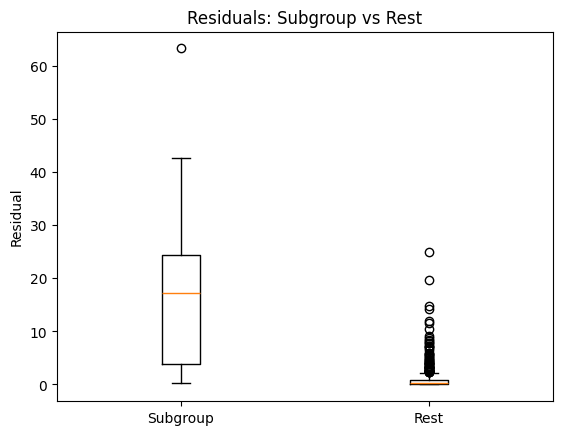


Rule 2: RAD == 24 AND LSTAT <= 9.53


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:273: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


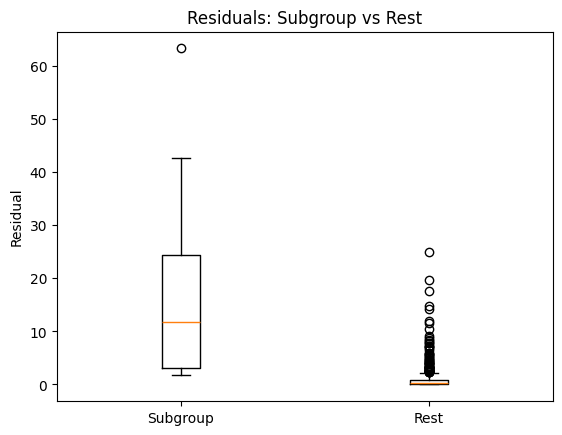


Rule 3: DIS <= 2.64 AND LSTAT <= 9.53 AND PTRATIO > 16.6


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:273: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


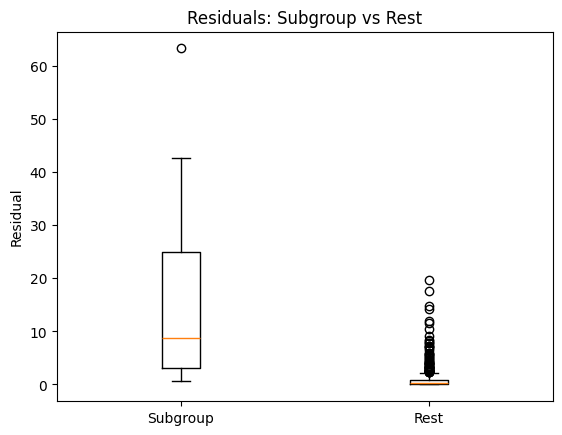


Rule 4: DIS <= 1.951 AND LSTAT <= 9.53 AND INDUS <= 18.1


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:273: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


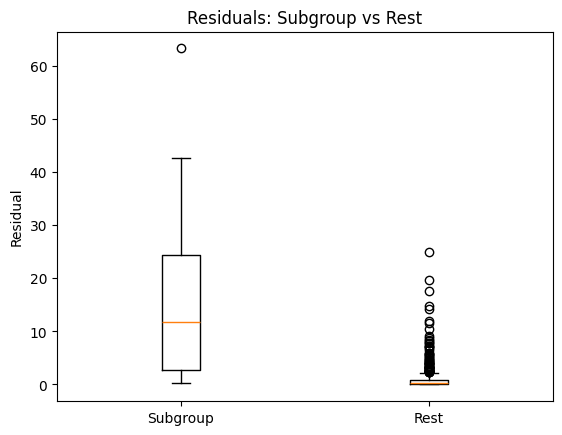


Rule 5: DIS <= 1.951 AND LSTAT <= 9.53 AND ZN <= 0


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:273: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


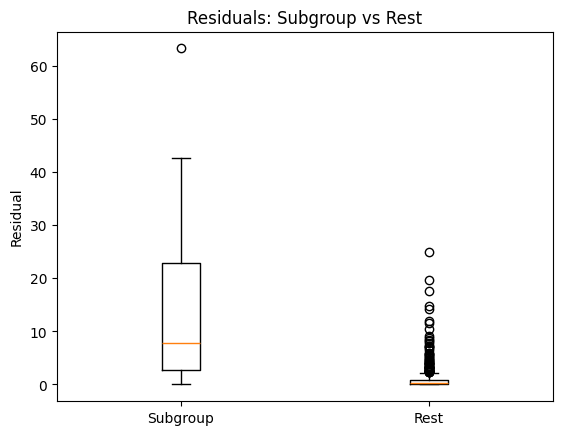

In [11]:
# Boxplot for top-5 rules
for i in range(5):
    print(f"\nRule {i+1}: {results.loc[i,'rule']}")
    plot_rule_vs_rest_boxplot(df, results.loc[i, 'rule'], resid_col="Residual")


In [12]:
import numpy as np

def q_residual_for_mask(mask, resid, mean_g, var_g):
    n = int(mask.sum())
    if n == 0 or var_g == 0: return 0.0
    mean_s = resid[mask].mean()
    return abs(mean_s - mean_g) / np.sqrt(var_g / n)

def permutation_pvalue(df, rule_str, resid_col="Residual", n_perm=2000, seed=0):
    rng = np.random.default_rng(seed)
    # reconstruct mask from rule string (uses the helper in your script)
    mask = np.ones(len(df), dtype=bool)
    for clause in rule_str.split(" AND "):
        feat, op, val = clause.split(" ", 2)
        if op == "==":
            try: v = type(df[feat].dropna().iloc[0])(eval(val))
            except Exception: v = val
            mask &= (df[feat].values == v)
        else:
            v = float(val)
            mask &= (df[feat].values <= v) if op=="<=" else (df[feat].values > v)

    resid = df[resid_col].to_numpy()
    mean_g = float(np.nanmean(resid))
    var_g  = float(np.nanvar(resid))
    q_obs  = q_residual_for_mask(mask, resid, mean_g, var_g)

    greater = 0
    for _ in range(n_perm):
        resid_perm = resid.copy()
        rng.shuffle(resid_perm)
        q_perm = q_residual_for_mask(mask, resid_perm, mean_g, var_g)
        greater += (q_perm >= q_obs)
    pval = (greater + 1) / (n_perm + 1)
    return q_obs, pval

# Example: test top 10 rules
for i in range(10):
    rule = results.loc[i, 'rule']
    qobs, p = permutation_pvalue(df, rule, resid_col="Residual", n_perm=1000, seed=42)
    print(f"{i+1:02d}. q={qobs:.2f}  p≈{p:.4f}  |  {rule}")


01. q=13.27  p≈0.0010  |  DIS <= 1.951 AND LSTAT <= 13.33 AND PTRATIO > 16.6
02. q=12.36  p≈0.0010  |  RAD == 24 AND LSTAT <= 9.53
03. q=12.83  p≈0.0010  |  DIS <= 2.64 AND LSTAT <= 9.53 AND PTRATIO > 16.6
04. q=12.02  p≈0.0010  |  DIS <= 1.951 AND LSTAT <= 9.53 AND INDUS <= 18.1
05. q=11.89  p≈0.0010  |  DIS <= 1.951 AND LSTAT <= 9.53 AND ZN <= 0
06. q=11.81  p≈0.0010  |  DIS <= 2.64 AND LSTAT <= 9.53 AND PTRATIO > 18.4
07. q=12.40  p≈0.0010  |  DIS <= 1.951 AND target > 19.7 AND PTRATIO > 16.6
08. q=11.57  p≈0.0010  |  DIS <= 1.951 AND LSTAT <= 13.33 AND INDUS <= 18.1
09. q=11.10  p≈0.0010  |  LSTAT <= 9.53 AND INDUS > 12.83 AND PTRATIO > 16.6
10. q=10.95  p≈0.0010  |  DIS <= 1.951 AND LSTAT <= 9.53 AND CRIM > 0.5501


In [13]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

def compute_cv_residuals(df, feature_cols, target_col="target", n_splits=5, seed=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oos_pred = np.empty(len(df), dtype=float)
    for train_idx, test_idx in kf.split(df):
        Xtr, Xte = df.iloc[train_idx][feature_cols], df.iloc[test_idx][feature_cols]
        ytr = df.iloc[train_idx][target_col]
        m = RandomForestRegressor(n_estimators=200, random_state=seed)
        m.fit(Xtr, ytr)
        oos_pred[test_idx] = m.predict(Xte)
    return (df[target_col].to_numpy() - oos_pred) ** 2

# build CV residuals and re-mine
feature_cols = [c for c in df.columns if c not in {"target","Residual"}]
df['Residual_CV'] = compute_cv_residuals(df, feature_cols, target_col="target", n_splits=5)
results_cv = mine_conj_rules(df, resid_col="Residual_CV", max_rule_len=3, top_k=100)
results_cv.to_csv("emm_lconj_results_cv.csv", index=False)

# Compare overlap of top rules
top_rules_in  = set(results.head(30)['rule'])
top_rules_oos = set(results_cv.head(30)['rule'])
print("Stable rules (in-sample ∩ out-of-sample):", len(top_rules_in & top_rules_oos))


Stable rules (in-sample ∩ out-of-sample): 3


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s) or is_bool_dtype(s) or (CATEGORICAL_AS_OBJECT and is_object_dtype(s)):
/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:117: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s):


In [14]:
def prune_by_coverage(df, results_df, resid_col="Residual", min_new=0.3):
    """Keep a rule if ≥ min_new fraction of its covered points are not yet covered."""
    kept = []
    covered = np.zeros(len(df), dtype=bool)
    for _, row in results_df.sort_values("q_residual", ascending=False).iterrows():
        # build mask
        mask = np.ones(len(df), dtype=bool)
        for clause in row['rule'].split(" AND "):
            feat, op, val = clause.split(" ", 2)
            if op == "==":
                try: v = type(df[feat].dropna().iloc[0])(eval(val))
                except Exception: v = val
                mask &= (df[feat].values == v)
            else:
                v = float(val)
                mask &= (df[feat].values <= v) if op=="<=" else (df[feat].values > v)
        n = int(mask.sum())
        if n == 0: continue
        new_frac = (~covered & mask).sum() / n
        if new_frac >= min_new:
            kept.append(row)
            covered |= mask
    return pd.DataFrame(kept).reset_index(drop=True)

results_diverse = prune_by_coverage(df, results, min_new=0.4)
results_diverse.to_csv("emm_lconj_results_diverse.csv", index=False)


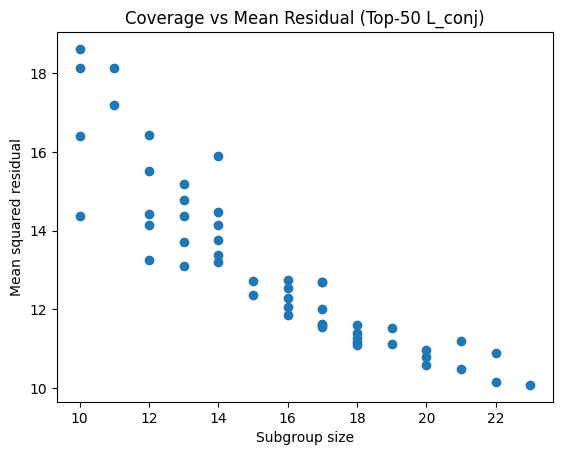

In [15]:
# Coverage vs mean residual
import matplotlib.pyplot as plt
r = results.head(50)
plt.figure()
plt.scatter(r['size'], r['mean_residual'])
plt.xlabel("Subgroup size")
plt.ylabel("Mean squared residual")
plt.title("Coverage vs Mean Residual (Top-50 L_conj)")
plt.show()


# Polynomial

In [16]:
# ===== L_poly basis builder (degree ≤ 2) =====
from typing import Iterable
from sklearn.feature_selection import mutual_info_regression

# Global registry mapping poly feature -> its base features set (for constraints)
POLY_BASES: Dict[str, set] = {}

def _numeric_cols_for_poly(df: pd.DataFrame, exclude: Iterable[str]) -> List[str]:
    from pandas.api.types import is_numeric_dtype
    cols = []
    for c in df.columns:
        if c in exclude: 
            continue
        if is_numeric_dtype(df[c]):
            cols.append(c)
    return cols

def _safe_name_sq(c: str) -> str:
    return f"{c}^2"

def _safe_name_ix(a: str, b: str) -> str:
    aa, bb = sorted([a, b])
    return f"{aa}*{bb}"

def _mi_or_corr(x: np.ndarray, y: np.ndarray, rng=None) -> float:
    # Mutual information for ranking; falls back to |corr| if MI fails
    try:
        mi = mutual_info_regression(x.reshape(-1,1), y, random_state=0)
        return float(mi[0])
    except Exception:
        # Pearson |corr|
        if np.std(x) == 0 or np.std(y) == 0: 
            return 0.0
        return float(abs(np.corrcoef(x, y)[0,1]))

def augment_with_poly(
    df: pd.DataFrame,
    resid_col: str = "Residual",
    max_squares: int = 8,
    max_interactions: int = 8,
    candidate_feature_limit: int = 10,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Builds a compact degree-2 polynomial basis:
      - rank single features by association with Residual, pick top 'candidate_feature_limit'
      - among them: create squares, rank by MI with Residual, keep top 'max_squares'
      - create pairwise interactions among shortlisted features, rank by MI, keep top 'max_interactions'
    Adds columns with readable names, updates POLY_BASES for constraints, returns df with new cols.
    """
    rng = np.random.default_rng(random_state)
    y = df[resid_col].to_numpy()
    # 1) shortlist numeric base features
    base_feats = _numeric_cols_for_poly(df, exclude={resid_col, "MEDV"})
    if len(base_feats) == 0:
        return df
    # rank base features by |corr| with Residual to pick a candidate pool
    feat_scores = [(f, _mi_or_corr(df[f].to_numpy(), y)) for f in base_feats]
    feat_scores.sort(key=lambda t: t[1], reverse=True)
    cand_feats = [f for f,_ in feat_scores[:max(3, min(candidate_feature_limit, len(feat_scores)))]]

    # 2) build and rank squares
    sq_candidates = []
    for f in cand_feats:
        name = _safe_name_sq(f)
        x2 = (df[f].to_numpy() ** 2)
        score = _mi_or_corr(x2, y)
        sq_candidates.append((name, f, x2, score))
    sq_candidates.sort(key=lambda t: t[3], reverse=True)
    chosen_squares = sq_candidates[:max_squares]

    # 3) build and rank pairwise interactions
    ix_candidates = []
    for i in range(len(cand_feats)):
        for j in range(i+1, len(cand_feats)):
            a, b = cand_feats[i], cand_feats[j]
            name = _safe_name_ix(a, b)
            xij = (df[a].to_numpy() * df[b].to_numpy())
            score = _mi_or_corr(xij, y)
            ix_candidates.append((name, (a,b), xij, score))
    ix_candidates.sort(key=lambda t: t[3], reverse=True)
    chosen_ix = ix_candidates[:max_interactions]

    # 4) add to df + register bases
    df_poly = df.copy()
    added = 0
    POLY_BASES.clear()
    for name, f, x2, _ in chosen_squares:
        if name in df_poly.columns: 
            continue
        df_poly[name] = x2
        POLY_BASES[name] = {f}
        added += 1
    for name, (a,b), xij, _ in chosen_ix:
        if name in df_poly.columns: 
            continue
        df_poly[name] = xij
        POLY_BASES[name] = {a, b}
        added += 1
    print(f"[L_poly] Added {added} polynomial features "
          f"({len(chosen_squares)} squares, {len(chosen_ix)} interactions).")
    return df_poly


In [17]:
# ===== Replace is_conflict and level_extend to enforce L_poly constraints =====

def _is_poly_feature(feat: str) -> bool:
    return (feat in POLY_BASES) or ("^2" in feat) or ("*" in feat)

def _poly_bases_of(feat: str) -> set:
    if feat in POLY_BASES:
        return set(POLY_BASES[feat])
    # fallback best-effort parse (if user provided their own poly columns)
    if "^2" in feat:
        return {feat.split("^2")[0]}
    if "*" in feat:
        a,b = feat.split("*", 1)
        return {a, b}
    return set()

def _rule_ok_with(preds: Tuple[Predicate, ...], new_pred: Optional[Predicate]=None) -> bool:
    """Enforce: 
       - ≤ 1 polynomial term per rule
       - If a poly term is present, none of its base features may also appear in the rule
    """
    all_preds = preds + ((new_pred,) if new_pred is not None else tuple())
    poly_count = 0
    used_feats = set()
    poly_bases_used = set()

    for p in all_preds:
        used_feats.add(p.feature)
        if _is_poly_feature(p.feature):
            poly_count += 1
            poly_bases_used |= _poly_bases_of(p.feature)

    if poly_count > 1:
        return False

    # Don’t allow mixing a poly feature with its base(s) in the same rule
    if poly_count == 1:
        # if any base feature is also used directly, reject
        if len(poly_bases_used & used_feats) > 0:
            return False

    return True

def is_conflict(existing: Tuple[Predicate, ...], cand: Predicate) -> bool:
    """
    Keep original L_conj guard: don't allow two predicates on the same feature.
    L_poly guard: _rule_ok_with must be satisfied.
    """
    # same-feature constraint
    if cand.feature in {p.feature for p in existing}:
        return True
    # poly constraints
    if not _rule_ok_with(existing, cand):
        return True
    return False

def level_extend(
    base_rules: List[Rule],
    uni_preds: List[Predicate],
    resid: np.ndarray,
    mean_global: float,
    var_global: float
) -> List[Rule]:
    seen_masks = set()
    next_rules: List[Rule] = []
    for r in base_rules:
        for p in uni_preds:
            if is_conflict(r.preds, p):
                continue
            new_mask = r.mask & p.mask
            n = int(new_mask.sum())
            if n < MIN_SUPPORT:
                continue
            key = new_mask.tobytes()
            if key in seen_masks:
                continue
            seen_masks.add(key)
            size, mean_sub, q = compute_q_residual(new_mask, resid, mean_global, var_global)
            new_rule = Rule(preds=r.preds + (p,), mask=new_mask, size=size, mean_resid=mean_sub, q=q)
            next_rules.append(new_rule)
    next_rules.sort(key=lambda r: r.q, reverse=True)
    return next_rules[:BEAM_WIDTH]


In [18]:
MAX_RULE_LEN = 2  # short rules are much more readable with poly terms


In [19]:
# 1) Build a compact L_poly basis using your current residuals
df_poly = augment_with_poly(
    df,
    resid_col="Residual",
    max_squares=8,            # tune as you like (2–12 is typical)
    max_interactions=8,       # tune as you like
    candidate_feature_limit=10
)

# 2) Mine as usual (the conflict logic now enforces poly readability)
results_poly = mine_conj_rules(
    df_poly,
    resid_col="Residual",
    max_rule_len=2,           # recommended for poly
    top_k=50
)

print(f"Global mean residual: {results_poly.attrs['global_mean_residual']:.4f}")
results_poly.head(20)


[L_poly] Added 16 polynomial features (8 squares, 8 interactions).
Global mean residual: 1.4393


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s) or is_bool_dtype(s) or (CATEGORICAL_AS_OBJECT and is_object_dtype(s)):
/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:117: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s):


,rule,length,size,mean_residual,delta_from_global,q_residual
0,RAD == 24 AND LSTAT <= 9.53,2,10,18.622819,17.183500,12.363340
1,INDUS*Residual_CV > 106.5 AND LSTAT <= 9.53,2,31,10.618601,9.179283,11.628235
2,Residual_CV*target > 244.8 AND DIS <= 1.951,2,21,12.590272,11.150953,11.626415
3,CRIM*Residual_CV > 14.95 AND LSTAT <= 9.53,2,18,13.442260,12.002941,11.586390
4,DIS*Residual_CV > 34.13 AND ZN <= 20,2,72,7.214298,5.774979,11.149128
5,DIS*Residual_CV > 34.13 AND RAD == 24,2,26,11.045393,9.606074,11.144403
6,Residual_CV*target > 244.8 AND RAD == 24,2,27,10.811553,9.372234,11.080241
7,DIS*Residual_CV > 34.13 AND NOX > 0.442,2,74,7.073102,5.633783,11.026564
8,INDUS*Residual_CV > 106.5 AND LSTAT <= 13.33,2,46,8.570880,7.131562,11.004942
9,AGE*Residual_CV > 732.7 AND LSTAT <= 9.53,2,40,9.001089,7.561771,10.881223


In [20]:
# L_conj (original) on df
results_conj = mine_conj_rules(df, resid_col="Residual", max_rule_len=3, top_k=50)

# quick side-by-side top-10 q’s
print(
    pd.DataFrame({
        "L_conj_q": results_conj["q_residual"].head(10).to_list(),
        "L_poly_q": results_poly["q_residual"].head(10).to_list(),
    })
)


    L_conj_q   L_poly_q
0  12.724743  12.363340
1  12.613768  11.628235
2  12.591557  11.626415
3  12.580438  11.586390
4  12.573627  11.149128
5  12.524170  11.144403
6  12.363340  11.080241
7  12.315894  11.026564
8  12.309329  11.004942
9  12.120593  10.881223


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s) or is_bool_dtype(s) or (CATEGORICAL_AS_OBJECT and is_object_dtype(s)):
/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:117: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s):


# DTREE

In [21]:
# ===== L_tree: shallow decision-tree subgroup miner for residual EMM =====
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Optional
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

# --- Config ---
LTREE_MAX_DEPTH = 3
LTREE_MIN_LEAF = 10          # minimum samples in a leaf/subgroup
LTREE_RANDOM_STATE = 42
RESID_COL = "Residual"       # change if your residual column name differs

# --- q_residual ---
def _q_residual(mask: np.ndarray, resid: np.ndarray, mean_g: float, var_g: float) -> Tuple[int, float, float]:
    n = int(mask.sum())
    if n == 0:
        return 0, np.nan, -np.inf
    mean_s = resid[mask].mean()
    denom = np.sqrt(var_g / n) if var_g > 0 else 0.0
    q = (abs(mean_s - mean_g) / denom) if denom > 0 else 0.0
    return n, mean_s, q

# --- numeric features only (keeps rules readable) ---
def _numeric_feature_frame(df: pd.DataFrame, exclude: set) -> pd.DataFrame:
    from pandas.api.types import is_numeric_dtype
    cols = [c for c in df.columns if c not in exclude and is_numeric_dtype(df[c])]
    X = df[cols].copy()
    # Coerce to float for tree safety
    for c in cols:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    X = X.replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(method="bfill")
    return X

# --- extract human-readable path for a given leaf ---
def _extract_rule_from_leaf(tree: DecisionTreeRegressor, feature_names: List[str], leaf_id: int) -> Tuple[str, int]:
    t = tree.tree_
    # Reconstruct a path by walking back from leaf: we can do a DFS to find all root->leaf paths once and cache
    paths = []

    def dfs(node_id, path):
        if t.children_left[node_id] == -1 and t.children_right[node_id] == -1:
            # leaf
            paths.append((node_id, path.copy()))
            return
        feat_idx = t.feature[node_id]
        thr = t.threshold[node_id]
        # left: feature <= thr
        left_clause = (feat_idx, "<=", thr)
        dfs(t.children_left[node_id], path + [left_clause])
        # right: feature > thr
        right_clause = (feat_idx, ">", thr)
        dfs(t.children_right[node_id], path + [right_clause])

    # Build all paths once
    if not hasattr(tree, "_all_paths_cache"):
        dfs(0, [])
        tree._all_paths_cache = {leaf: path for leaf, path in paths}

    path = tree._all_paths_cache[leaf_id]
    # Translate to readable clauses; merge same-feature bounds for niceness
    clauses = []
    for feat_idx, op, thr in path:
        feat = feature_names[feat_idx]
        # round threshold for readability
        thr_disp = float(np.round(thr, 4))
        clauses.append(f"{feat} {op} {thr_disp}")
    return " AND ".join(clauses), len(clauses)

# --- main miner ---
def mine_ltree_rules(
    df: pd.DataFrame,
    resid_col: str = RESID_COL,
    max_depth: int = LTREE_MAX_DEPTH,
    min_leaf: int = LTREE_MIN_LEAF,
    top_k: int = 50,
    random_state: int = LTREE_RANDOM_STATE,
    exclude_cols: Optional[set] = None,
) -> pd.DataFrame:
    if exclude_cols is None:
        exclude_cols = {resid_col, "MEDV", "Residual_CV"}
    assert resid_col in df.columns, f"Residual column '{resid_col}' not found."

    # Build X (numeric-only) and y
    X = _numeric_feature_frame(df, exclude=exclude_cols)
    feature_names = list(X.columns)
    if len(feature_names) == 0:
        raise ValueError("No numeric features available for L_tree mining.")
    y = df[resid_col].to_numpy()

    # Fit shallow tree on residuals
    tree = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_leaf,
        random_state=random_state
    )
    tree.fit(X, y)

    # Which leaf does each sample fall into?
    leaf_ids = tree.apply(X.to_numpy())
    # Global stats
    resid = y
    mean_g = float(np.nanmean(resid))
    var_g  = float(np.nanvar(resid))

    # Aggregate leaves -> groups
    groups = {}
    for i, lid in enumerate(leaf_ids):
        groups.setdefault(lid, []).append(i)

    # Score each leaf subgroup
    rows = []
    for lid, idxs in groups.items():
        idxs = np.array(idxs, dtype=int)
        if idxs.size < min_leaf:
            continue
        mask = np.zeros(len(df), dtype=bool)
        mask[idxs] = True
        size, mean_s, q = _q_residual(mask, resid, mean_g, var_g)
        rule_str, length = _extract_rule_from_leaf(tree, feature_names, lid)
        rows.append({
            "rule": rule_str,
            "length": length,
            "size": size,
            "mean_residual": mean_s,
            "delta_from_global": mean_s - mean_g,
            "q_residual": q,
            "leaf_id": int(lid),
        })

    if not rows:
        return pd.DataFrame(columns=["rule","length","size","mean_residual","delta_from_global","q_residual","leaf_id"])

    # Rank by q, keep top_k
    out = pd.DataFrame(rows).sort_values("q_residual", ascending=False).head(top_k).reset_index(drop=True)
    out.attrs["global_mean_residual"] = mean_g
    out.attrs["global_var_residual"] = var_g
    out.attrs["feature_names"] = feature_names
    out.attrs["tree"] = tree
    return out

# --- optional: mask builder from rule string to reuse existing plot helper ---
def mask_from_rule_string(df: pd.DataFrame, rule_str: str) -> np.ndarray:
    mask = np.ones(len(df), dtype=bool)
    if not rule_str.strip():
        return mask
    for clause in rule_str.split(" AND "):
        feat, op, val = clause.split(" ", 2)
        v = float(val)
        if op == "<=":
            mask &= (df[feat].values <= v)
        elif op == ">":
            mask &= (df[feat].values > v)
        else:
            raise ValueError(f"Unsupported operator in L_tree clause: {op}")
    return mask


In [22]:
# Mine L_tree subgroups (depth ≤ 3), score with q_residual, get top-50
results_tree = mine_ltree_rules(
    df,
    resid_col="Residual",
    max_depth=3,
    min_leaf=10,         # tune per data size; 10–25 works well on Boston
    top_k=50,
    random_state=42
)
print(f"Global mean residual: {results_tree.attrs['global_mean_residual']:.4f}")
results_tree.head(20)


Global mean residual: 1.4393


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4292856045.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(method="bfill")
/Users/aniket/Environments/env_ml_3_12_10/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


,rule,length,size,mean_residual,delta_from_global,q_residual,leaf_id
0,DIS <= 1.3387,1,10,12.632326,11.193007,8.053246,1
1,DIS > 1.3387 AND RM > 8.037,2,12,9.217493,7.778174,6.130452,6
2,DIS > 1.3387 AND RM <= 8.037 AND target <= 35.0,3,451,0.875432,-0.563886,2.724608,4
3,DIS > 1.3387 AND RM <= 8.037 AND target > 35.0,3,33,2.925516,1.486198,1.942485,5


rows: 4
                                              rule  length  size  \
0                                    DIS <= 1.3387       1    10   
1                      DIS > 1.3387 AND RM > 8.037       2    12   
2  DIS > 1.3387 AND RM <= 8.037 AND target <= 35.0       3   451   

   mean_residual  delta_from_global  q_residual  leaf_id  
0      12.632326          11.193007    8.053246        1  
1       9.217493           7.778174    6.130452        6  
2       0.875432          -0.563886    2.724608        4  

Rule 1: DIS <= 1.3387


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:273: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


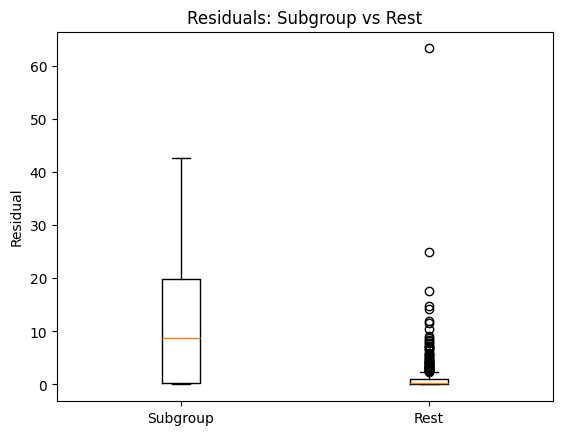


Rule 2: DIS > 1.3387 AND RM > 8.037


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:273: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


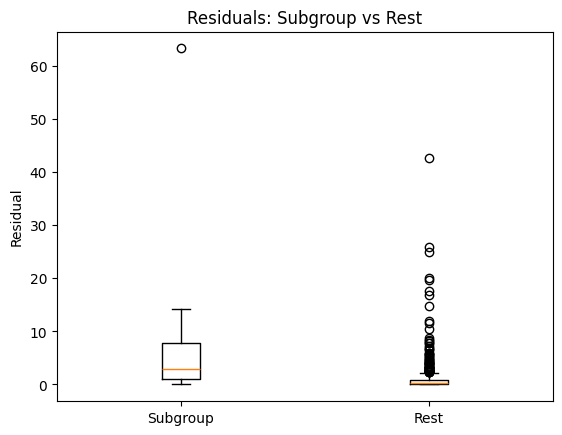


Rule 3: DIS > 1.3387 AND RM <= 8.037 AND target <= 35.0


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:273: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


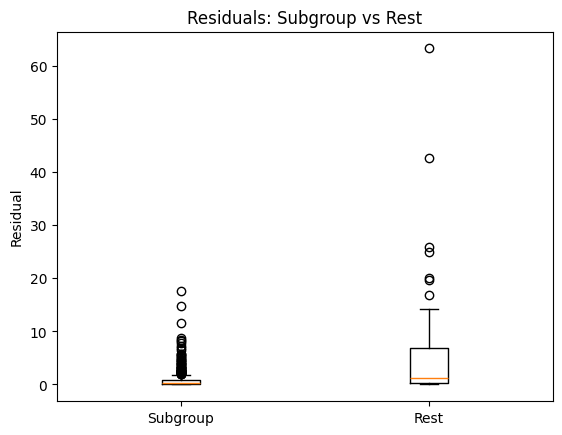


Rule 4: DIS > 1.3387 AND RM <= 8.037 AND target > 35.0


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:273: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


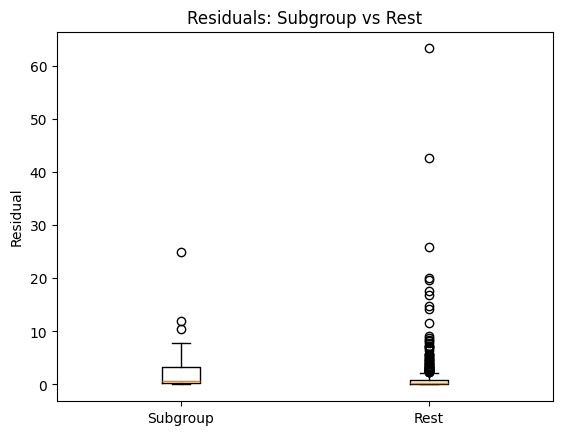

In [23]:
# Show what's in results_tree
print("rows:", len(results_tree))
print(results_tree.head(3))

# If empty, try relaxing the tree params and re-mine
if len(results_tree) == 0:
    results_tree = mine_ltree_rules(
        df,
        resid_col="Residual",   # or "Residual_CV"
        max_depth=3,            # try 3 or 4
        min_leaf=5,             # relax from 10 -> 5
        top_k=50,
        random_state=42
    )
    print("re-mined rows:", len(results_tree))

# Visualize top-N safely
N = min(5, len(results_tree))
for i in range(N):
    rule_i = results_tree.iloc[i]['rule']   # iloc avoids label issues
    print(f"\nRule {i+1}: {rule_i}")
    plot_rule_vs_rest_boxplot(df, rule_i, resid_col="Residual")


# Symb

In [27]:
# # ===== L_symb: symbolic-expression subgroup miner =====
# from gplearn.genetic import SymbolicRegressor
# import numpy as np, pandas as pd

# def mine_lsymb_rules(
#     df: pd.DataFrame,
#     resid_col: str = "Residual",
#     feature_exclude: set = {"Residual","Residual_CV","MEDV"},
#     n_expr: int = 30,          # number of symbolic expressions to keep
#     max_depth: int = 3,
#     pop_size: int = 300,
#     generations: int = 10,
#     min_support: int = 10,
#     top_k: int = 50,
#     random_state: int = 42,
# ):
#     from pandas.api.types import is_numeric_dtype

#     # --- numeric X, residual y ---
#     X = df[[c for c in df.columns if c not in feature_exclude and is_numeric_dtype(df[c])]].copy()
#     y = df[resid_col].to_numpy()

#     # train small symbolic regressor on residuals
#     symb = SymbolicRegressor(
#         population_size=pop_size,
#         generations=generations,
#         stopping_criteria=0.0,
#         const_range=(-5,5),
#         init_depth=(2, max_depth),
#         function_set=("add","sub","mul","div"),
#         metric="mean absolute error",
#         parsimony_coefficient=0.001,
#         p_crossover=0.7,
#         p_subtree_mutation=0.1,
#         p_hoist_mutation=0.05,
#         p_point_mutation=0.1,
#         max_samples=1.0,
#         verbose=0,
#         random_state=random_state
#     )
#     symb.fit(X, y)
#     expr_strs = symb._programs[-1]  # last gen
#     # flatten and clean valid programs
#     all_expr = [p for gen in expr_strs if gen is not None for p in gen if p is not None]

#     # pick top n_expr unique formulas by R^2 (stored in fitness)
#     uniq = {}
#     for p in all_expr:
#         s = str(p)
#         if s not in uniq:
#             uniq[s] = p
#     progs = sorted(uniq.values(), key=lambda p: getattr(p, "fitness_", 0), reverse=True)[:n_expr]

#     mean_g = float(np.nanmean(y))
#     var_g  = float(np.nanvar(y))
#     rows=[]
#     for p in progs:
#         expr = str(p)
#         try:
#             vals = p.execute(X.values)
#         except Exception:
#             continue
#         if np.all(np.isnan(vals)): continue
#         # Build simple thresholds = quantiles (25%, 50%, 75%)
#         qs = np.quantile(vals[np.isfinite(vals)], [0.25,0.5,0.75])
#         for thr in qs:
#             for op in ("<=",">"):
#                 mask = (vals <= thr) if op=="<=" else (vals > thr)
#                 n, mean_s, q = compute_q_residual(mask, y, mean_g, var_g)
#                 if n < min_support: continue
#                 rule_str = f"{expr} {op} {thr:.4f}"
#                 rows.append({
#                     "rule": rule_str,
#                     "size": n,
#                     "mean_residual": mean_s,
#                     "delta_from_global": mean_s - mean_g,
#                     "q_residual": q,
#                     "expr": expr,
#                     "operator": op,
#                     "threshold": thr
#                 })
#     if not rows:
#         return pd.DataFrame(columns=["rule","size","mean_residual","delta_from_global","q_residual"])
#     out = pd.DataFrame(rows).sort_values("q_residual", ascending=False).head(top_k).reset_index(drop=True)
#     out.attrs["global_mean_residual"] = mean_g
#     out.attrs["global_var_residual"] = var_g
#     return out

# ===== Dependency-free L_symb (symbolic-expression) subgroup miner =====
# Builds simple expressions over numeric features and mines threshold rules using q_residual.

from typing import List, Tuple, Dict, Callable, Any, Optional
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

# Reuse your compute_q_residual from earlier; if not present, uncomment this:
# def compute_q_residual(sub_mask, resid, mean_global, var_global):
#     n = int(sub_mask.sum())
#     if n == 0: return 0, np.nan, -np.inf
#     mean_sub = resid[sub_mask].mean()
#     denom = np.sqrt(var_global / n) if var_global > 0 and n > 0 else 0.0
#     q = (abs(mean_sub - mean_global) / denom) if denom > 0 else 0.0
#     return n, mean_sub, q

def _numeric_frame(df: pd.DataFrame, exclude: set) -> pd.DataFrame:
    cols = [c for c in df.columns if c not in exclude and is_numeric_dtype(df[c])]
    X = df[cols].copy()
    for c in cols:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    X = X.replace([np.inf, -np.inf], np.nan)
    # simple impute to avoid NaNs breaking arithmetic
    X = X.fillna(X.median(numeric_only=True))
    return X

def _rank_features_by_assoc(X: pd.DataFrame, y: np.ndarray, k: int) -> List[str]:
    # rank by |corr| with residuals; fall back to variance if constant
    scores = []
    for c in X.columns:
        x = X[c].to_numpy()
        if np.std(x) == 0 or np.std(y) == 0:
            s = 0.0
        else:
            s = abs(np.corrcoef(x, y)[0,1])
        scores.append((c, float(s)))
    scores.sort(key=lambda t: t[1], reverse=True)
    return [c for c,_ in scores[:max(3, min(k, len(scores)))]]

def _eps(x: np.ndarray) -> float:
    # small stabilizer scaled to data
    s = float(np.nanstd(x))
    return 1e-8 if s == 0 else 1e-6 * s

def _safe_div(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    with np.errstate(divide='ignore', invalid='ignore'):
        res = a / np.where(b == 0, np.nan, b)
    # replace inf/nan from division by small stabilized denom
    bad = ~np.isfinite(res)
    if bad.any():
        res[bad] = a[bad] / (b[bad] + _eps(b))
    return res

def _gen_expressions(X: pd.DataFrame, bases: List[str],
                     max_triplets: int = 30) -> List[Tuple[str, Callable[[Dict[str, np.ndarray]], np.ndarray], int]]:
    """
    Returns list of (expr_str, evaluator, n_ops) with ≤3 operators (depth ≤ 2).
    Operators allowed: +, -, *, / ; forms:
      unary:        f
      binary:       f1 + f2, f1 - f2, f1 * f2, f1 / f2
      nested (≤3 ops): (f1+f2)/f3, (f1-f2)/f3, (f1*f2)/f3, (f1/f2)+f3, (f1/f2)-f3
    """
    exprs = []

    # map feature -> vector
    F = {c: X[c].to_numpy() for c in bases}

    # unary
    for a in bases:
        exprs.append( (f"{a}", (lambda a=a: (lambda F: F[a]))(), 0) )

    # binary
    for i, a in enumerate(bases):
        for j, b in enumerate(bases):
            if j <= i: continue
            exprs += [
                (f"({a} + {b})", (lambda a=a,b=b: (lambda F: F[a] + F[b]))(), 1),
                (f"({a} - {b})", (lambda a=a,b=b: (lambda F: F[a] - F[b]))(), 1),
                (f"({b} - {a})", (lambda a=a,b=b: (lambda F: F[b] - F[a]))(), 1),
                (f"({a} * {b})", (lambda a=a,b=b: (lambda F: F[a] * F[b]))(), 1),
                (f"({a} / {b})", (lambda a=a,b=b: (lambda F: _safe_div(F[a], F[b])))(), 1),
                (f"({b} / {a})", (lambda a=a,b=b: (lambda F: _safe_div(F[b], F[a])))(), 1),
            ]

    # nested (≤3 ops)
    nested = []
    # pick up to max_triplets distinct triplets to control explosion
    triplets = []
    for a in bases:
        for b in bases:
            if b == a: continue
            for c in bases:
                if c==a or c==b: continue
                triplets.append((a,b,c))
    triplets = triplets[:max_triplets]

    for a,b,c in triplets:
        nested += [
            (f"({a} + {b}) / {c}", (lambda a=a,b=b,c=c: (lambda F: _safe_div(F[a]+F[b], F[c])))(), 2),
            (f"({a} - {b}) / {c}", (lambda a=a,b=b,c=c: (lambda F: _safe_div(F[a]-F[b], F[c])))(), 2),
            (f"({a} * {b}) / {c}", (lambda a=a,b=b,c=c: (lambda F: _safe_div(F[a]*F[b], F[c])))(), 2),
            (f"({a} / {b}) + {c}", (lambda a=a,b=b,c=c: (lambda F: _safe_div(F[a],F[b]) + F[c]))(), 2),
            (f"({a} / {b}) - {c}", (lambda a=a,b=b,c=c: (lambda F: _safe_div(F[a],F[b]) - F[c]))(), 2),
        ]
    exprs.extend(nested)

    # de-duplicate by string
    seen = set()
    uniq = []
    for s, fn, nops in exprs:
        if s not in seen:
            uniq.append((s, fn, nops))
            seen.add(s)
    return uniq

def mine_lsymb_rules_light(
    df: pd.DataFrame,
    resid_col: str = "Residual",
    feature_exclude: set = {"Residual","Residual_CV","MEDV"},
    top_features: int = 8,          # shortlist features by |corr| with residual
    max_triplets: int = 40,         # limit nested expression combos
    thresholds_per_expr: int = 3,   # number of quantile thresholds per expression
    min_support: int = 10,
    top_k: int = 50,
) -> pd.DataFrame:

    assert resid_col in df.columns, f"Residual column '{resid_col}' not found."
    X = _numeric_frame(df, exclude=feature_exclude | {resid_col})
    y = df[resid_col].to_numpy()
    mean_g = float(np.nanmean(y))
    var_g  = float(np.nanvar(y))

    # shortlist features most associated with residuals
    bases = _rank_features_by_assoc(X, y, k=top_features)
    if len(bases) < 2:
        raise ValueError("Not enough numeric features to build symbolic expressions.")

    # generate simple expressions (≤3 operators)
    exprs = _gen_expressions(X, bases, max_triplets=max_triplets)

    rows = []
    for expr_str, fn, nops in exprs:
        try:
            vals = fn({c: X[c].to_numpy() for c in X.columns})
        except Exception:
            continue
        if vals is None: 
            continue
        vals = np.asarray(vals, dtype=float)
        if not np.isfinite(vals).any():
            continue
        # choose interior quantile thresholds
        finite_vals = vals[np.isfinite(vals)]
        if finite_vals.size < min_support:
            continue
        qs = np.linspace(0,1,thresholds_per_expr+2)[1:-1]  # e.g., 25/50/75th for 3
        thr_list = np.unique(np.quantile(finite_vals, qs, method="linear"))
        for thr in thr_list:
            for op in ("<=", ">"):
                mask = (vals <= thr) if op=="<=" else (vals > thr)
                n, mean_s, q = compute_q_residual(mask, y, mean_g, var_g)
                if n < min_support: 
                    continue
                rows.append({
                    "rule": f"{expr_str} {op} {float(thr):.6g}",
                    "size": n,
                    "length": nops + 1,  # crude complexity proxy
                    "mean_residual": mean_s,
                    "delta_from_global": mean_s - mean_g,
                    "q_residual": q,
                    "expr": expr_str,
                    "operator": op,
                    "threshold": float(thr),
                    "n_ops": nops
                })

    if not rows:
        return pd.DataFrame(columns=["rule","size","length","mean_residual","delta_from_global","q_residual","expr","operator","threshold","n_ops"])

    out = pd.DataFrame(rows).sort_values("q_residual", ascending=False).head(top_k).reset_index(drop=True)
    out.attrs["global_mean_residual"] = mean_g
    out.attrs["global_var_residual"] = var_g
    out.attrs["bases_used"] = bases
    return out


In [31]:
# === REPLACE your plot_rule_vs_rest_boxplot with this generalized version ===
import numpy as np
import matplotlib.pyplot as plt

def plot_rule_vs_rest_boxplot(df, rule_str, resid_col="Residual"):
    """
    Supports:
      1) Conjunctive rules: "feat1 <= a AND feat2 > b AND feat3 == c"
      2) Symbolic rules:    "<expression> <= thr" or "<expression> > thr"
         where <expression> uses valid column names and +,-,*,/ and parentheses,
         e.g., "(LSTAT / RM) - DIS > -0.299116"
    """
    rule_str = rule_str.strip()
    mask = np.ones(len(df), dtype=bool)

    def _boxplot_from_mask(m):
        data = [df.loc[m, resid_col].values, df.loc[~m, resid_col].values]
        labels = ["Subgroup", "Rest"]
        plt.figure()
        plt.boxplot(data, labels=labels, showfliers=True)
        plt.title("Residuals: Subgroup vs Rest")
        plt.ylabel(resid_col)
        plt.show()

    # Heuristic: if there's an " AND " -> treat as conjunctive
    if " AND " in rule_str:
        # Conjunctive case (existing behavior)
        for clause in rule_str.split(" AND "):
            feat, op, val = clause.split(" ", 3)[:3]
            if op == "==":
                # equality (string or numeric)
                v = val
                try:
                    v = type(df[feat].dropna().iloc[0])(eval(val))
                except Exception:
                    # leave as string
                    pass
                mask &= (df[feat].values == v)
            else:
                v = float(val)
                if op == "<=":
                    mask &= (df[feat].values <= v)
                elif op == ">":
                    mask &= (df[feat].values > v)
                else:
                    raise ValueError(f"Unsupported operator: {op}")
        _boxplot_from_mask(mask)
        return

    # Otherwise: treat as a single symbolic expression OP threshold
    # We look for the last occurrence of " <= " or " > " to split expr and threshold.
    if " <= " in rule_str:
        expr_str, thr_str = rule_str.rsplit(" <= ", 1)
        op = "<="
    elif " > " in rule_str:
        expr_str, thr_str = rule_str.rsplit(" > ", 1)
        op = ">"
    else:
        raise ValueError(f"Unrecognized rule format: {rule_str}")

    # Evaluate the expression safely with a limited namespace:
    # map each valid column name to its numpy array
    local_ns = {col: df[col].to_numpy() for col in df.columns}
    # Allow only arithmetic ops via Python eval (no builtins)
    try:
        vals = eval(expr_str, {"__builtins__": {}}, local_ns)
    except Exception as e:
        raise ValueError(f"Failed to evaluate expression '{expr_str}': {e}")

    vals = np.asarray(vals, dtype=float)
    thr = float(thr_str)
    mask = (vals <= thr) if op == "<=" else (vals > thr)
    _boxplot_from_mask(mask)


In [29]:
results_symb = mine_lsymb_rules_light(
    df,
    resid_col="Residual",
    feature_exclude={"Residual","Residual_CV","MEDV"},
    top_features=8,
    max_triplets=40,
    thresholds_per_expr=3,
    min_support=8,
    top_k=50
)

print(f"Global mean residual: {results_symb.attrs['global_mean_residual']:.4f}")
results_symb.head(20)


Global mean residual: 1.4393


,rule,size,length,mean_residual,delta_from_global,q_residual,expr,operator,threshold,n_ops
0,(target / LSTAT) - DIS > -0.299116,127,3,3.516823,2.077505,5.326821,(target / LSTAT) - DIS,>,-0.299116,2
1,(target * RM) / DIS > 54.5289,127,3,3.456421,2.017103,5.171947,(target * RM) / DIS,>,54.528905,2
2,(target / DIS) + RM > 15.0536,127,3,3.429592,1.990273,5.103155,(target / DIS) + RM,>,15.053562,2
3,(DIS * LSTAT) <= 27.5006,127,2,3.370877,1.931558,4.952607,(DIS * LSTAT),<=,27.500621,1
4,(target * AGE) > 1747.87,127,2,3.364086,1.924767,4.935194,(target * AGE),>,1747.870000,1
5,(target - RM) / DIS > 6.2096,127,3,3.363800,1.924481,4.934462,(target - RM) / DIS,>,6.209600,2
6,(target - NOX) / DIS > 8.59426,127,3,3.350656,1.911338,4.900761,(target - NOX) / DIS,>,8.594256,2
7,(target / DIS) - RM > 2.50093,127,3,3.348889,1.909570,4.896229,(target / DIS) - RM,>,2.500931,2
8,(target / DIS) - NOX > 8.25866,127,3,3.346218,1.906899,4.889379,(target / DIS) - NOX,>,8.258659,2
9,(target + NOX) / DIS > 9.08787,127,3,3.343414,1.904096,4.882192,(target + NOX) / DIS,>,9.087872,2



Rule 1: (target / LSTAT) - DIS > -0.299116


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/3317227985.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


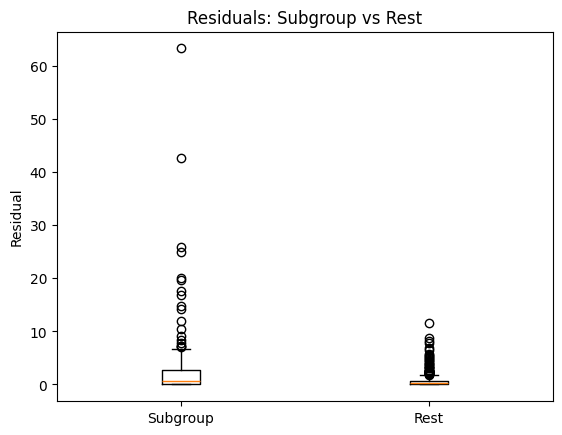


Rule 2: (target * RM) / DIS > 54.5289


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/3317227985.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


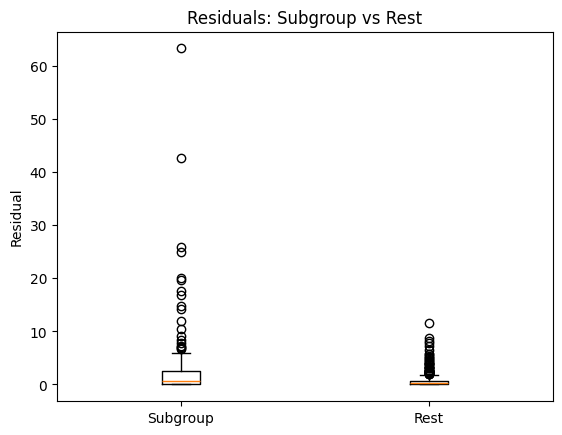


Rule 3: (target / DIS) + RM > 15.0536


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/3317227985.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


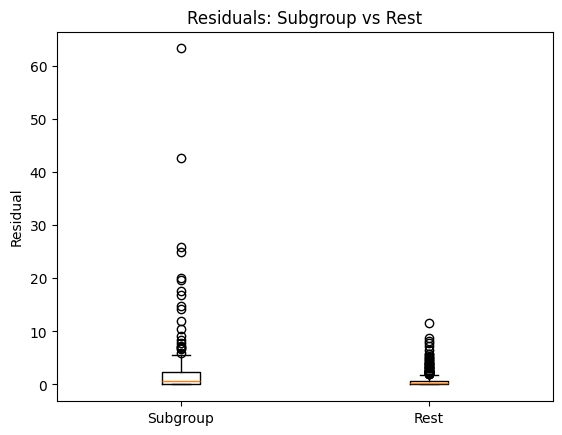


Rule 4: (DIS * LSTAT) <= 27.5006


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/3317227985.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


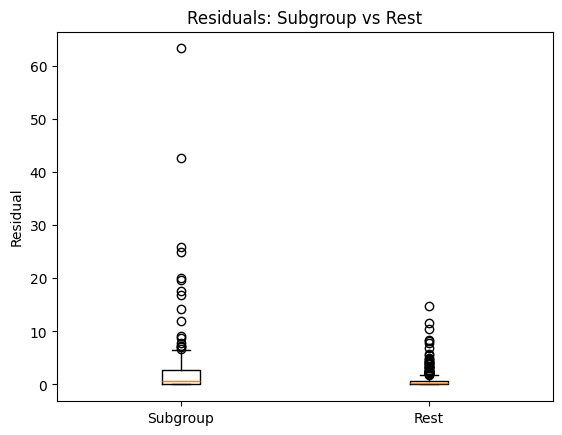


Rule 5: (target * AGE) > 1747.87


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/3317227985.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


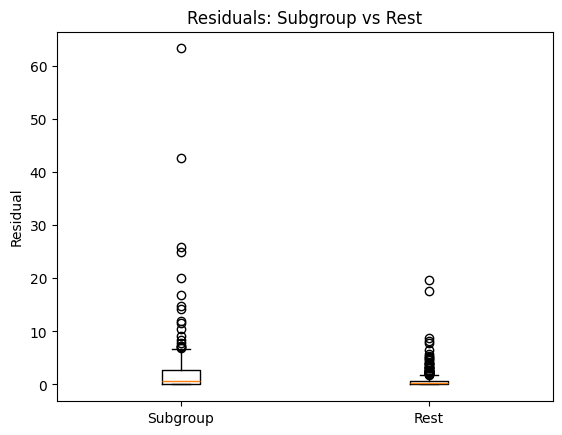

In [32]:
for i in range(min(5, len(results_symb))):
    rule = results_symb.iloc[i]['rule']
    print(f"\nRule {i+1}: {rule}")
    plot_rule_vs_rest_boxplot(df, rule, resid_col="Residual")


# Compare

/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s) or is_bool_dtype(s) or (CATEGORICAL_AS_OBJECT and is_object_dtype(s)):
/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:117: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s):
/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(s) or is_bool_dtype(s) or (CATEGORICAL_AS_OBJECT and is_object_dtype(s)):
/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4132249162.py:

[L_poly] Added 16 polynomial features (8 squares, 8 interactions).
Top 10 by quality (q_residual):


/var/folders/3x/_h4mr3l14wdd2fz4hllvdbm80000gn/T/ipykernel_75756/4292856045.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(method="bfill")
/Users/aniket/Environments/env_ml_3_12_10/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


,language,q_residual,size,mean_residual,delta_from_global,complexity,interpretability,rule
0,L_conj,12.724743,10,19.125123,17.685804,3,0.250000,DIS <= 1.951 AND LSTAT <= 9.53 AND Residual_CV...
1,L_conj,12.613768,13,16.815517,15.376199,3,0.250000,Residual_CV > 11.21 AND LSTAT <= 13.33 AND RAD...
2,L_conj,12.591557,11,18.125574,16.686255,3,0.250000,DIS <= 1.951 AND LSTAT <= 13.33 AND PTRATIO > ...
3,L_conj,12.580438,12,17.401085,15.961766,3,0.250000,Residual_CV > 11.21 AND target > 19.7 AND DIS ...
4,L_conj,12.573627,16,15.255130,13.815811,3,0.250000,Residual_CV > 11.21 AND LSTAT <= 9.53 AND DIS ...
5,L_conj,12.524170,13,16.706297,15.266979,3,0.250000,Residual_CV > 11.21 AND LSTAT <= 13.33 AND DIS...
6,L_conj,12.363340,10,18.622819,17.183500,2,0.333333,RAD == 24 AND LSTAT <= 9.53
7,L_poly,12.363340,10,18.622819,17.183500,2,0.333333,RAD == 24 AND LSTAT <= 9.53
8,L_conj,12.315894,14,15.906294,14.466975,3,0.250000,DIS <= 2.64 AND LSTAT <= 9.53 AND PTRATIO > 16.6
9,L_conj,12.309329,11,17.751568,16.312249,3,0.250000,Residual_CV > 11.21 AND LSTAT <= 9.53 AND NOX ...



Pareto front (q vs interpretability):


,language,q_residual,interpretability,complexity,size,rule
0,L_conj,12.724743,0.250000,3,10,DIS <= 1.951 AND LSTAT <= 9.53 AND Residual_CV...
6,L_conj,12.363340,0.333333,2,10,RAD == 24 AND LSTAT <= 9.53
7,L_poly,12.363340,0.333333,2,10,RAD == 24 AND LSTAT <= 9.53
157,L_poly,9.774109,0.500000,1,101,Residual_CV > 11.21


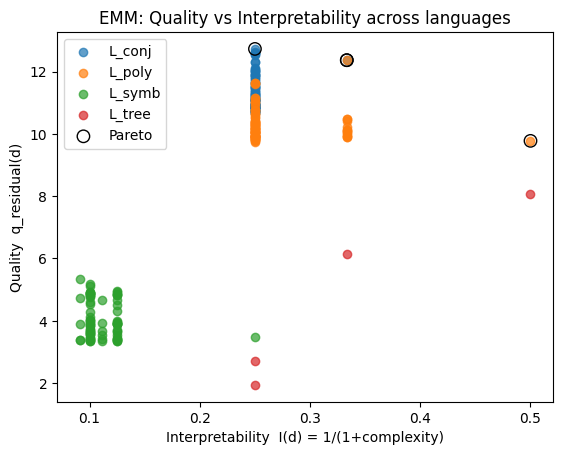

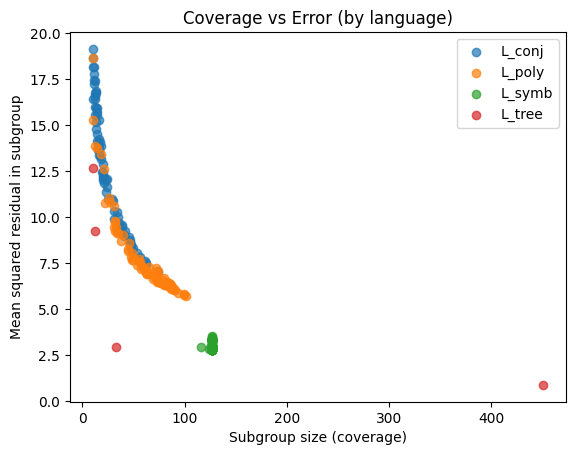

In [33]:
# =======================
# 1) RUN ALL FOUR MINERS
# =======================
# L_conj
results_conj = mine_conj_rules(
    df, resid_col="Residual", max_rule_len=3, top_k=80
)

# L_poly (degree ≤ 2 basis + readability guards already installed)
df_poly = augment_with_poly(
    df, resid_col="Residual",
    max_squares=8, max_interactions=8, candidate_feature_limit=10
)
results_poly = mine_conj_rules(
    df_poly, resid_col="Residual", max_rule_len=2, top_k=80
)

# L_tree
results_tree = mine_ltree_rules(
    df, resid_col="Residual", max_depth=3, min_leaf=8, top_k=80, random_state=42
)

# L_symb (dependency-free light enumerator)
results_symb = mine_lsymb_rules_light(
    df, resid_col="Residual",
    feature_exclude={"Residual","Residual_CV","MEDV"},
    top_features=8, max_triplets=40, thresholds_per_expr=3,
    min_support=8, top_k=80
)

# Guard empties
def _nonempty(x):
    return x if (isinstance(x, pd.DataFrame) and len(x)>0) else pd.DataFrame(
        columns=["rule","length","size","mean_residual","delta_from_global","q_residual"]
    )
results_conj = _nonempty(results_conj)
results_poly = _nonempty(results_poly)
results_tree = _nonempty(results_tree)
results_symb = _nonempty(results_symb)

# ==========================================
# 2) STANDARDIZE, COMPLEXITY & INTERPRETABILITY
# ==========================================
import re
import numpy as np
import pandas as pd

def _tokens(expr: str) -> int:
    # rough token count for expressions/rules (operands + operators)
    # counts names, numbers, and operators + - * / <= > == ( )
    return len(re.findall(r"[A-Za-z_]\w*|[-+/*()<>]=?|==|[\d.]+", expr))

def add_meta(df_rules: pd.DataFrame, lang: str) -> pd.DataFrame:
    if len(df_rules)==0:
        return df_rules
    out = df_rules.copy()
    out["language"] = lang

    # Complexity models per language (simple, auditable)
    if lang == "L_conj":
        # number of predicates in conjunction (we stored 'length'); fallback to count ' AND '
        if "length" in out.columns and out["length"].notna().all():
            comp = out["length"].astype(int)
        else:
            comp = out["rule"].str.count(r"\bAND\b") + 1
        out["complexity"] = comp

    elif lang == "L_poly":
        # reuse length if present, otherwise #clauses; plus small penalty for polynomial symbols (^2 or *)
        base = (out["rule"].str.count(r"\bAND\b") + 1).astype(int)
        poly_pen = out["rule"].str.count(r"\^2|\*").astype(int)
        out["complexity"] = base + poly_pen

    elif lang == "L_tree":
        # path length = number of threshold clauses
        path_len = (out["rule"].str.count(r"\bAND\b") + 1).astype(int)
        out["complexity"] = path_len

    elif lang == "L_symb":
        # #operators + operands proxy via token count; keep small
        # also include 1 for the threshold comparison
        out["complexity"] = out["rule"].apply(_tokens)

    # Interpretability I(d) = 1/(1+complexity)  (higher is more interpretable)
    out["interpretability"] = 1.0 / (1.0 + out["complexity"].astype(float))
    return out

C_conj = add_meta(results_conj, "L_conj")
C_poly = add_meta(results_poly, "L_poly")
C_tree = add_meta(results_tree, "L_tree")
C_symb = add_meta(results_symb, "L_symb")

# ============================
# 3) MERGE & RANK COMPARISONS
# ============================
all_rules = pd.concat([C_conj, C_poly, C_tree, C_symb], ignore_index=True)
all_rules = all_rules.sort_values("q_residual", ascending=False).reset_index(drop=True)

print("Top 10 by quality (q_residual):")
display(all_rules[["language","q_residual","size","mean_residual","delta_from_global","complexity","interpretability","rule"]].head(10))

# Save for paper
all_rules.to_csv("emm_all_languages_results.csv", index=False)

# =================================
# 4) COMPUTE A PARETO FRONT (q vs I)
# =================================
def pareto_front(df: pd.DataFrame, q_col="q_residual", i_col="interpretability"):
    pts = df[[q_col, i_col]].to_numpy()
    idxs = []
    for i, (q,i_) in enumerate(pts):
        dominated = ((pts[:,0] >= q) & (pts[:,1] >= i_) & ((pts[:,0] > q) | (pts[:,1] > i_))).any()
        if not dominated:
            idxs.append(i)
    return df.iloc[idxs].sort_values([q_col, i_col], ascending=[False, False])

pf = pareto_front(all_rules)
pf.to_csv("emm_pareto_front.csv", index=False)

print("\nPareto front (q vs interpretability):")
display(pf[["language","q_residual","interpretability","complexity","size","rule"]].head(20))

# ===========================
# 5) VISUALIZE COMPARISONS
# ===========================
import matplotlib.pyplot as plt

# Scatter: quality vs interpretability by language
plt.figure()
for lang, dfg in all_rules.groupby("language"):
    plt.scatter(dfg["interpretability"], dfg["q_residual"], label=lang, alpha=0.7)
plt.scatter(pf["interpretability"], pf["q_residual"], edgecolor="k", facecolor="none", s=80, label="Pareto")
plt.xlabel("Interpretability  I(d) = 1/(1+complexity)")
plt.ylabel("Quality  q_residual(d)")
plt.title("EMM: Quality vs Interpretability across languages")
plt.legend()
plt.show()

# Coverage vs mean residual, colored by language
plt.figure()
for lang, dfg in all_rules.groupby("language"):
    plt.scatter(dfg["size"], dfg["mean_residual"], label=lang, alpha=0.7)
plt.xlabel("Subgroup size (coverage)")
plt.ylabel("Mean squared residual in subgroup")
plt.title("Coverage vs Error (by language)")
plt.legend()
plt.show()


# New V2

In [1]:
import pandas as pd
from scipy.io import arff

In [2]:
arff_file = arff.loadarff('/Users/aniket/Downloads/regression_datasets/auto-mpg.arff')
df = pd.DataFrame(arff_file[0])

In [ ]:
df["cylinders"] = df["cylinders"].astype(int)
df["model"] = df["model"].astype(int)
df["origin"] = df["origin"].astype(int)

In [4]:
df["cylinders"].value_counts()

cylinders
b'4'    204
b'8'    103
b'6'     84
b'3'      4
b'5'      3
Name: count, dtype: int64

In [5]:
df

,cylinders,displacement,horsepower,weight,acceleration,model,origin,class
0,b'8',307.0,130.0,3504.0,12.0,b'70',b'1',18.0
1,b'8',350.0,165.0,3693.0,11.5,b'70',b'1',15.0
2,b'8',318.0,150.0,3436.0,11.0,b'70',b'1',18.0
3,b'8',304.0,150.0,3433.0,12.0,b'70',b'1',16.0
4,b'8',302.0,140.0,3449.0,10.5,b'70',b'1',17.0
...,...,...,...,...,...,...,...,...
393,b'4',140.0,86.0,2790.0,15.6,b'82',b'1',27.0
394,b'4',97.0,52.0,2130.0,24.6,b'82',b'2',44.0
395,b'4',135.0,84.0,2295.0,11.6,b'82',b'1',32.0
396,b'4',120.0,79.0,2625.0,18.6,b'82',b'1',28.0


In [ ]:
df["model"].value_counts()


model
b'73'    40
b'78'    36
b'76'    34
b'82'    31
b'75'    30
b'70'    29
b'79'    29
b'80'    29
b'81'    29
b'71'    28
b'72'    28
b'77'    28
b'74'    27
Name: count, dtype: int64

In [7]:
df["origin"].value_counts()


origin
b'1'    249
b'3'     79
b'2'     70
Name: count, dtype: int64

In [10]:
int(df["origin"][0])

1

In [16]:
df = pd.read_csv('/Users/aniket/github/Exceptional_Model_Mining_2AMM20/datasets/cmc.data', header=None, names=['Wife_Age','Wife_Education','Husband_Education','Children',
                                                'Wife_religion','Wife_working','Husband_Occupation','SOLI',
                                                'Media_Exposure','Contraceptive_Method'])
df.head()


,Wife_Age,Wife_Education,Husband_Education,Children,Wife_religion,Wife_working,Husband_Occupation,SOLI,Media_Exposure,Contraceptive_Method
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [13]:
column_names

['class']

In [12]:
df

class
24 2 3 3  1 1 2 3 0      1
45 1 3 10 1 1 3 4 0      1
43 2 3 7  1 1 3 4 0      1
42 3 2 9  1 1 3 3 0      1
36 3 3 8  1 1 3 2 0      1
...                    ...
33 4 4 2  1 0 2 4 0      3
       3  1 1 1 4 0      3
39 3 3 8  1 0 1 4 0      3
33 3 3 4  1 0 2 2 0      3
17 3 3 1  1 1 2 4 0      3

[1473 rows x 1 columns]

In [36]:
dataset_information = {
    "boston": {
        "file_name": "boston_housing.csv",
        "target": "MEDV",
    },
    "forestfire": {"file_name": "forestfires.csv", "target": "area"},
    "auto_mpg": {"file_name": "auto-mpg.arff", "target": "class"},
    "cmc": {"file_name": "cmc.data", "target": "Wife_Age"},
}
# for dataset_name, dataset_information in dataset_information.items():
#     print(dataset_name)
#     file_name = dataset_information["file_name"]
#     target = dataset_information["target"]
#     print(file_name)
#     print(target)
#     print()

In [37]:
dataset_information

{'boston': {'file_name': 'boston_housing.csv', 'target': 'MEDV'},
 'forestfire': {'file_name': 'forestfires.csv', 'target': 'area'},
 'auto_mpg': {'file_name': 'auto-mpg.arff', 'target': 'class'},
 'cmc': {'file_name': 'cmc.data', 'target': 'Wife_Age'}}

In [38]:
for dataset_name, data_information in dataset_information.items():
    print(dataset_name)
    file_name = data_information["file_name"]
    target = data_information["target"]

boston
forestfire
auto_mpg
cmc


In [39]:
for dataset_name, data_information in dataset_information.items():
    print(dataset_name)
    file_name = data_information["file_name"]
    target = data_information["target"]
    print(file_name)
    print(target)
    print()
    if file_name == "boston.csv":
        boston = fetch_openml(name="boston", version=1, as_frame=True)
        df = boston.frame
    elif file_name == "forestfires.csv":
        df = pd.read_csv("/Users/aniket/github/Exceptional_Model_Mining_2AMM20/datasets/forestfires.csv")
        # Do strings to integer conversion.
        month_map = {
            'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
            'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
            'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
        }

        day_map = {
            'sun': 1, 'mon': 2, 'tue': 3, 'wed': 4,
            'thu': 5, 'fri': 6, 'sat': 7
        }

        df['day_int'] = df['day'].map(day_map)
        df['month_int'] = df['month'].map(month_map)
    elif file_name == "auto-mpg.arff":
        arff_file = arff.loadarff('/Users/aniket/Downloads/regression_datasets/auto-mpg.arff')
        df = pd.DataFrame(arff_file[0])
        df["cylinders"] = df["cylinders"].astype(int)
        df["model"] = df["model"].astype(int)
        df["origin"] = df["origin"].astype(int)
    elif file_name == "cmc.data":
        df = pd.read_csv(
            "/Users/aniket/github/Exceptional_Model_Mining_2AMM20/datasets/cmc.data",
            header=None,
            names=[
                "Wife_Age",
                "Wife_Education",
                "Husband_Education",
                "Children",
                "Wife_religion",
                "Wife_working",
                "Husband_Occupation",
                "SOLI",
                "Media_Exposure",
                "Contraceptive_Method",
            ],
        )
    else:
        print("You messed sth up dumdum. Everything is hardcoded BWAHAHAHA")
    name = file_name.split(".")[0]
    model = RandomForestRegressor(
        random_state=DEFAULT_RANDOM_STATE, n_estimators=NUM_ESTIMATORS
    )
    model.fit(df.drop("target", axis=1), df["target"])

    y_pred = model.predict(df.drop("target", axis=1))

    for actual, pred in list(zip(df["target"][:5], y_pred[:5])):
        print(f"Actual target: {actual:.1f}, Predicted target: {pred:.2f}")

    df["Residual_signed"] = df["target"] - y_pred

    residuals = (df["target"] - y_pred) ** 2
    df["Residual"] = residuals

    # build CV residuals and re-mine
    feature_cols = [c for c in df.columns if c not in {"target", "Residual"}]
    df["Residual_CV"] = compute_cv_residuals(
        df,
        feature_cols,
        target_col="target",
        n_splits=NUM_SPLITS,
        seed=DEFAULT_RANDOM_STATE,
    )


    df.to_csv(
        f"dataset_with_residuals/{name}_with_residuals.csv", index=False
    )


boston
boston_housing.csv
MEDV

You messed sth up dumdum. Everything is hardcoded BWAHAHAHA


NameError: name 'RandomForestRegressor' is not defined

In [23]:
from sklearn.datasets import fetch_openml

In [ ]:
file_name = dataset_information["boston"]["file_name"]
target = dataset_information["boston"]["target"]

# Boston
boston = fetch_openml(name="boston", version=1, as_frame=True)
df = boston.frame

# Col name to target cuz i no wan retype
df.rename(columns={f"{target}": "target"}, inplace=True)

# Other datasets
df = pd.read_csv(
    "/Users/aniket/github/Exceptional_Model_Mining_2AMM20/datasets/cmc.data",
    header=None,
    names=[
        "Wife_Age",
        "Wife_Education",
        "Husband_Education",
        "Children",
        "Wife_religion",
        "Wife_working",
        "Husband_Occupation",
        "SOLI",
        "Media_Exposure",
        "Contraceptive_Method",
    ],
)
df.head()


KeyError: 'boston'

In [25]:
df = pd.read_csv("/Users/aniket/github/Exceptional_Model_Mining_2AMM20/datasets/forestfires.csv")

In [27]:
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [28]:
df["month"].value_counts()

month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: count, dtype: int64

In [30]:
df["day"].value_counts()

day
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: count, dtype: int64